**BEFORE MODIFICATION ON MODEL AND DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Number of Classes:  4
{0: 'durian', 1: 'pumpkin', 2: 'tomato', 3: 'watermelon'}
Train Data Size:  521
Test Data Size:  323




/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)




Epoch: 1/30
Epoch : 000, Training: Loss: 1.5685, Accuracy: 27.2553%, 
		Validation : Loss : 1.6470, Accuracy: 12.0743%, Time: 4.5823s
Epoch: 2/30
Epoch : 001, Training: Loss: 1.1665, Accuracy: 44.1459%, 
		Validation : Loss : 2.0741, Accuracy: 16.4087%, Time: 4.4674s
Epoch: 3/30
Epoch : 002, Training: Loss: 1.0503, Accuracy: 52.9750%, 
		Validation : Loss : 1.9371, Accuracy: 20.7430%, Time: 4.4324s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.9633, Accuracy: 59.1171%, 
		Validation : Loss : 1.8563, Accuracy: 24.4582%, Time: 4.4535s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.8939, Accuracy: 65.4511%, 
		Validation : Loss : 1.7297, Accuracy: 29.1022%, Time: 4.4259s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.8515, Accuracy: 68.9060%, 
		Validation : Loss : 1.7224, Accuracy: 30.0310%, Time: 4.3560s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.7965, Accuracy: 72.7447%, 
		Validation : Loss : 1.6671, Accuracy: 34.0557%, Time: 4.4172s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.7518, Accuracy: 7

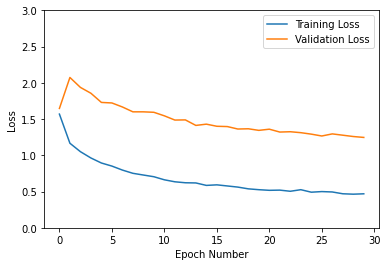

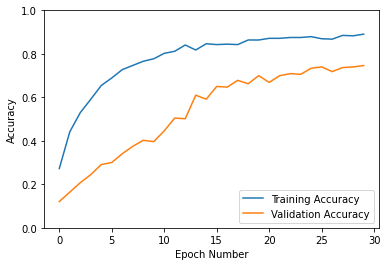



Accuracy of the network on the 323 test images: 74 %


In [ ]:
%matplotlib inline
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

##### Applying Data Augmentation to Increase the dataset size #####
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],       #this cannot be change
                             [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

##### Load the Data #####
# Set train and valid directory paths

dataset = '/content/drive/MyDrive/fruit_dataset/'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'validation')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 32

# Number of classes
num_classes = len(os.listdir(train_directory))
print('Number of Classes: ', num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=False)

print('Train Data Size: ', train_data_size)
print('Test Data Size: ', test_data_size)
print('\n')

input_size = (3,256,256)

##### Turn train and test custom Dataset's into DataLoader's #####
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=32, # how many samples per batch?
                                     num_workers=2, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=32, 
                                    num_workers=2, 
                                    shuffle=False) # don't usually need to shuffle testing data

classes = ('durian','pumpkin','tomato','watermelon')

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##### Apply Model #####

model_conv = torchvision.models.resnet18(pretrained=True)       #Pre-Trained Model
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0001, momentum=0.9)

##### Calculate training time #####
import time 

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model_conv, history

##### RUN THE TRAINING #####
print('\n')
num_epochs = 30
trained_model, history = train_and_validate(model_conv, criterion, optimizer_conv, num_epochs)

##### Analyze the loss curve #####
print('\n')
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

##### Analyze the accuracy curve #####
print('\n')
plt.plot(history[:,2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

##### Check Accuracy of Network #####
print('\n')
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model_conv(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 323 test images: {100 * correct // total} %')

**AFTER MODIFICATION ON MODEL AND DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Number of Classes:  4
{0: 'durian', 1: 'pumpkin', 2: 'tomato', 3: 'watermelon'}
Train Data Size:  1200
Test Data Size:  160




/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)




Epoch: 1/30
Epoch : 000, Training: Loss: 1.1476, Accuracy: 59.1667%, 
		Validation : Loss : 0.7585, Accuracy: 92.5000%, Time: 14.3746s
Epoch: 2/30
Epoch : 001, Training: Loss: 0.6030, Accuracy: 93.3333%, 
		Validation : Loss : 0.4277, Accuracy: 94.3750%, Time: 14.7102s
Epoch: 3/30
Epoch : 002, Training: Loss: 0.3656, Accuracy: 96.5000%, 
		Validation : Loss : 0.3036, Accuracy: 94.3750%, Time: 14.6090s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.2914, Accuracy: 95.8333%, 
		Validation : Loss : 0.2653, Accuracy: 95.6250%, Time: 14.7966s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.2446, Accuracy: 97.3333%, 
		Validation : Loss : 0.2054, Accuracy: 97.5000%, Time: 14.3159s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.2149, Accuracy: 97.5833%, 
		Validation : Loss : 0.2006, Accuracy: 95.6250%, Time: 14.4187s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.1915, Accuracy: 97.6667%, 
		Validation : Loss : 0.1722, Accuracy: 98.1250%, Time: 14.4669s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.1737, Accu

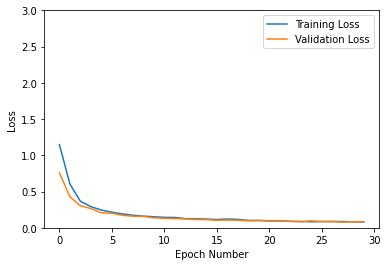

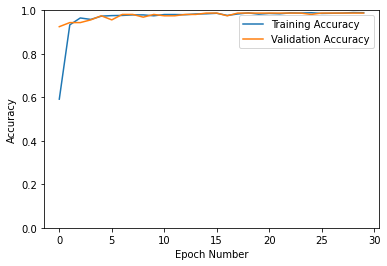



Accuracy of the network on the 160 test images: 98 %


In [ ]:
%matplotlib inline
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

##### Applying Data Augmentation to Increase the dataset size #####
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],       #this cannot be change
                             [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

##### Load the Data #####
# Set train and valid directory paths

dataset = '/content/drive/MyDrive/fruit_dataset_new/'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'validation')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 64

# Number of classes
num_classes = len(os.listdir(train_directory))
print('Number of Classes: ', num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=False)

print('Train Data Size: ', train_data_size)
print('Test Data Size: ', test_data_size)
print('\n')

input_size = (3,256,256)

##### Turn train and test custom Dataset's into DataLoader's #####
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=64, # how many samples per batch?
                                     num_workers=2, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=64, 
                                    num_workers=2, 
                                    shuffle=False) # don't usually need to shuffle testing data

classes = ('durian','pumpkin','tomato','watermelon')

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##### Apply Model #####

model_conv = torchvision.models.resnet152(pretrained=True)       #Pre-Trained Model
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

##### Calculate training time #####
import time 

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model_conv, history

##### RUN THE TRAINING #####
print('\n')
num_epochs = 30
trained_model, history = train_and_validate(model_conv, criterion, optimizer_conv, num_epochs)

##### Analyze the loss curve #####
print('\n')
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

##### Analyze the accuracy curve #####
print('\n')
plt.plot(history[:,2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

##### Check Accuracy of Network #####
print('\n')
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model_conv(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 160 test images: {100 * correct // total} %')

In [61]:
#Building dictionary with all th einformation we need to completely rebuild the model
MyModel = {'input_size': input_size,
              'state_dict': model_conv.state_dict()}

torch.save(MyModel, '/content/drive/MyDrive/Colab_Notebooks/MyModel.pth')

In [60]:
# Specify a path
PATH = "/content/drive/MyDrive/Colab_Notebooks/entire_model.pt"

# Save
torch.save(model_conv, PATH)